# 1-With ScikitLearn (Cell By Cell) (Pipelines, Random Forest, GridSearchCV, Confusion Matrix)

### Import Modules

In [1]:
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score

## Fetch The Data (Choose Either 1 or 2)

```markdown
### 1-Download the Data from the source

In [ ]:
# Fetch dataset
dry_bean_dataset = fetch_ucirepo(id=602)

# Data (as pandas dataframes)
X = dry_bean_dataset.data.features
y = dry_bean_dataset.data.targets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


```markdown
### 2-Manually Import Data CSV

In [3]:
# Load the CSV file into a DataFrame with specified encoding
df = pd.read_csv(r"Dry_Bean_Dataset.csv", encoding='latin1')

# Set the 'Class' column as the target variable
X = df.drop(columns=['Class'])  # Features (attributes)
y = df['Class']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Remove single-dimensional entries from the shape of y

In [3]:
y = np.squeeze(y)

## Define Pieplines


### This pipeline encompasses the entire machine learning workflow, including feature selection, feature scaling, and model training. It consists of the following steps:
- Feature Selection: Uses the SelectKBest method with the chi-squared (chi2) scoring function to select the best features.
- Feature Scaling: Utilizes the previously defined scaler_pipeline to standardize the selected features.
- Random Forest Classifier: Trains a Random Forest classifier using the RandomForestClassifier class from scikit-learn, with a specified random state for reproducibility.

In [4]:
# Prepoccessing Pipeline
scaler_pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler())
    ]
)
# Random Forest Pipeline
random_forest_pipeline = Pipeline(
    steps=[
        ("feature_selection", SelectKBest(score_func=chi2)),
        ("scaler", scaler_pipeline),
        ("random_forest_classifier", RandomForestClassifier(random_state=42))
    ]
)

## Perform GridSearch With CV


### Specifies the hyperparameters and their respective values to be explored during the grid search process.

### Parameters
- feature_selection__k: Number of features to be selected using SelectKBest.
- random_forest_classifier__n_estimators: Number of trees in the Random Forest.
- random_forest_classifier__max_depth: Maximum depth of the trees.
- random_forest_classifier__min_samples_split: Minimum number of samples required to split an internal node.
- random_forest_classifier__min_samples_leaf: Minimum number of samples required to be at a leaf node.


In [5]:
# Define parameters for GridSearchCV tuning
param_grid = {
    "feature_selection__k": [5,8,10,12,16], #Number of K for feature Selection
    "random_forest_classifier__n_estimators": [50,100,200],
    "random_forest_classifier__max_depth": [None,10,20],
    "random_forest_classifier__min_samples_split": [2,5,10],
    "random_forest_classifier__min_samples_leaf": [1,2,4]
}

grid_search = GridSearchCV(estimator=random_forest_pipeline, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)

best_random_forest_pipeline = grid_search.best_estimator_
cv_scores = cross_val_score(best_random_forest_pipeline, X_train, y_train, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Parameters: {'feature_selection__k': 16, 'random_forest_classifier__max_depth': 20, 'random_forest_classifier__min_samples_leaf': 1, 'random_forest_classifier__min_samples_split': 5, 'random_forest_classifier__n_estimators': 50}
Cross-Validation Scores: [0.92332415 0.93112948 0.91551882 0.92650436 0.91961415]
Mean CV Accuracy: 0.9232181927008002


## Train The Model


### Provides a comprehensive overview of the process involved in training, evaluating, and explaining the best model selected using a random forest pipeline. It includes steps for training the model on the entire training set, making predictions on the test set, evaluating the model's performance through confusion matrix and classification report, and explaining the process of cross-validation for feature selection.

- We train the best model on the entire training set
- After training the model, we make predictions on the test set
- To evaluate the performance of our model, we compute the confusion matrix and classification report

In [6]:
# Train the best model on the entire training set
best_random_forest_pipeline.fit(X_train, y_train)

# Predict on the test set with the best model
y_pred = best_random_forest_pipeline.predict(X_test)

# Evaluate the best model
print("\nConfusion Matrix:")
confusion_matrix_logistic = confusion_matrix(y_test, y_pred)
print(confusion_matrix_logistic)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", test_accuracy)


Confusion Matrix:
[[234   0  17   0   1   1   8]
 [  0 117   0   0   0   0   0]
 [ 15   0 295   0   5   1   1]
 [  0   0   0 617   2   4  48]
 [  3   0   7   3 390   0   5]
 [  3   0   0  16   0 385   9]
 [  0   0   1  53   6   8 468]]

Classification Report:
              precision    recall  f1-score   support

    BARBUNYA       0.92      0.90      0.91       261
      BOMBAY       1.00      1.00      1.00       117
        CALI       0.92      0.93      0.93       317
    DERMASON       0.90      0.92      0.91       671
       HOROZ       0.97      0.96      0.96       408
       SEKER       0.96      0.93      0.95       413
        SIRA       0.87      0.87      0.87       536

    accuracy                           0.92      2723
   macro avg       0.93      0.93      0.93      2723
weighted avg       0.92      0.92      0.92      2723

Test Accuracy: 0.9203084832904884


## Plot Confusion Matrix, Learning Curve, Cross Validation Score

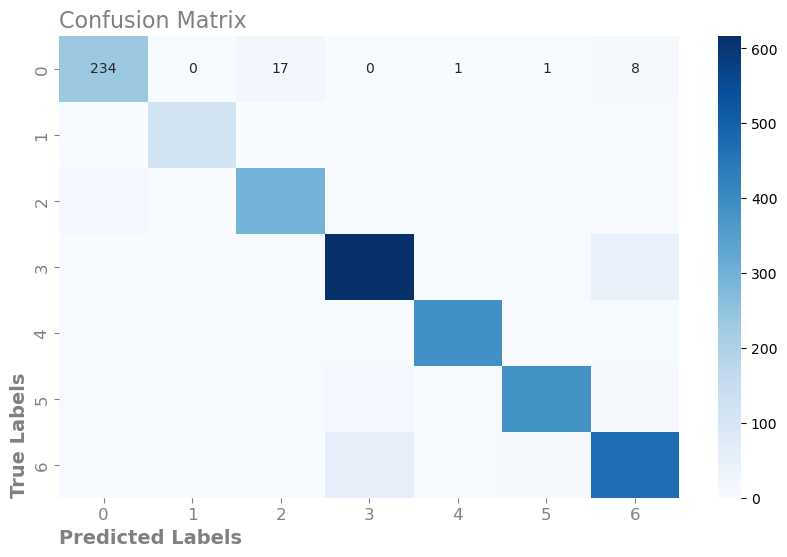

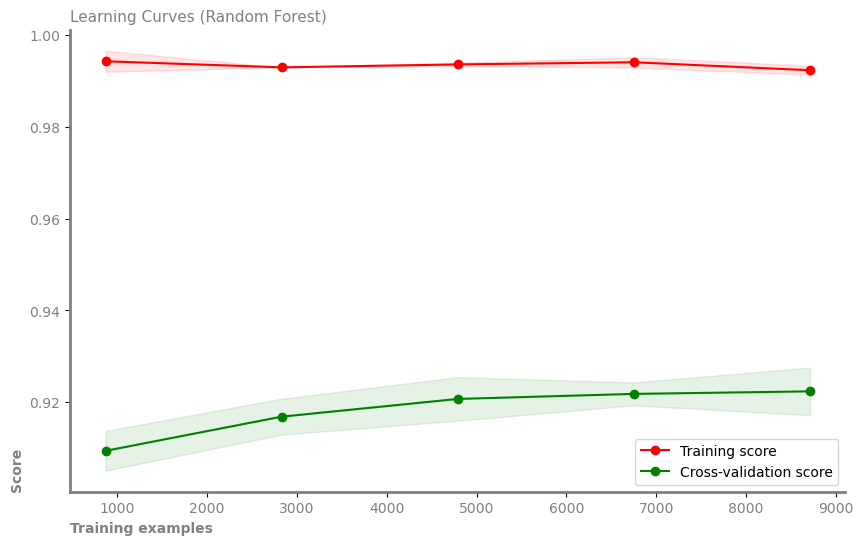

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix

# Plot Confusion Matrix
plt.figure(figsize=(10, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Adjusting style
ax = plt.gca()
ax.spines[['right', 'top']].set_visible(False)
ax.spines[['left', 'bottom']].set_color('gray')
ax.tick_params(axis='x', colors='gray', labelsize='large')
ax.tick_params(axis='y', colors='gray', labelsize='large')
ax.set_ylabel("True Labels", loc="bottom", weight="bold", fontsize=14, color="gray")
ax.set_xlabel("Predicted Labels", loc="left", weight="bold", fontsize=14, color="gray")

plt.title("Confusion Matrix", loc='left', fontsize=16, color="gray")
plt.show()

# Plot Learning Curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10, 6))
    plt.title(title, color='grey', loc='left', fontsize=11)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples", color='grey', fontsize=10, fontweight='bold', loc='left')
    plt.ylabel("Score", color='grey', fontsize=10, fontweight='bold', loc='bottom')
    plt.xticks(color='grey')
    plt.yticks(color='grey')
    plt.gca().spines['bottom'].set_color('grey')
    plt.gca().spines['bottom'].set_linewidth(2)
    plt.gca().spines['left'].set_color('grey')
    plt.gca().spines['left'].set_linewidth(2)
    sns.despine()
    plt.grid(False)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

title = "Learning Curves (Random Forest)"
plot_learning_curve(best_random_forest_pipeline, title, X_train, y_train, cv=5, n_jobs=-1)
plt.show()


# 2-With ScikitLearn (All in One) (Random Forest , GridSearchCV , Confusion Matrix)

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from ucimlrepo import fetch_ucirepo

# Fetch dataset
dry_bean_dataset = fetch_ucirepo(id=602)

# Data (as pandas dataframes)
X = dry_bean_dataset.data.features
y = dry_bean_dataset.data.targets
y = np.squeeze(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define hyperparameters grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

# Print best parameters found by Grid Search
print("Best Parameters:", grid_search.best_params_)

# Get the best model
best_rf_classifier = grid_search.best_estimator_

# Evaluate the best model with Cross-Validation
cv_scores = cross_val_score(best_rf_classifier, X_train_scaled, y_train, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

# Predict on the test set with the best model
y_pred = best_rf_classifier.predict(X_test_scaled)
confusion_matrix_logistic = confusion_matrix(y_test, y_pred)
# Evaluate the best model
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
# Calculate test accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", test_accuracy)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Cross-Validation Scores: [0.92332415 0.93112948 0.91551882 0.92696371 0.91961415]
Mean CV Accuracy: 0.9233100622460458

Confusion Matrix:
[[234   0  17   0   1   1   8]
 [  0 117   0   0   0   0   0]
 [ 15   0 295   0   5   1   1]
 [  0   0   0 617   2   4  48]
 [  3   0   7   3 390   0   5]
 [  3   0   0  16   0 385   9]
 [  0   0   1  53   6   8 468]]

Classification Report:
              precision    recall  f1-score   support

    BARBUNYA       0.92      0.90      0.91       261
      BOMBAY       1.00      1.00      1.00       117
        CALI       0.92      0.93      0.93       317
    DERMASON       0.90      0.92      0.91       671
       HOROZ       0.97      0.96      0.96       408
       SEKER       0.96      0.93      0.95       413
        SIRA       0.87      0.87      0.87       536

    accuracy          

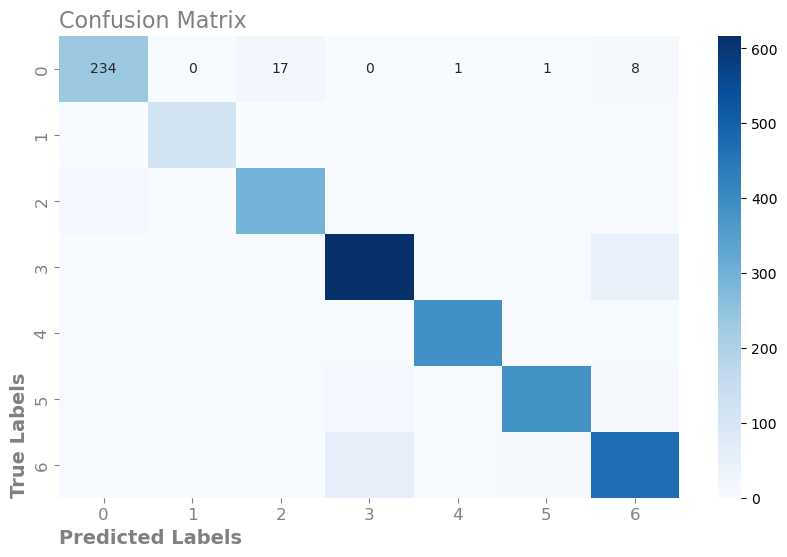

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Plot Confusion Matrix
plt.figure(figsize=(10, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Adjusting style
ax = plt.gca()
ax.spines[['right', 'top']].set_visible(False)
ax.spines[['left', 'bottom']].set_color('gray')
ax.tick_params(axis='x', colors='gray', labelsize='large')
ax.tick_params(axis='y', colors='gray', labelsize='large')
ax.set_ylabel("True Labels", loc="bottom", weight="bold", fontsize=14, color="gray")
ax.set_xlabel("Predicted Labels", loc="left", weight="bold", fontsize=14, color="gray")

plt.title("Confusion Matrix", loc='left', fontsize=16, color="gray")
plt.show()


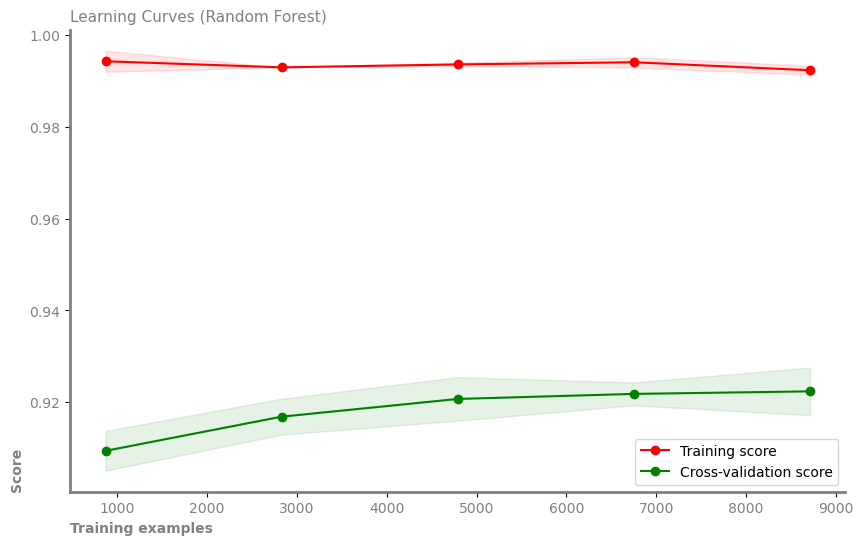

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve

# Plot Learning Curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10, 6))
    plt.title(title, color='grey', loc='left', fontsize=11)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples", color='grey', fontsize=10, fontweight='bold', loc='left')
    plt.ylabel("Score", color='grey', fontsize=10, fontweight='bold', loc='bottom')
    plt.xticks(color='grey')
    plt.yticks(color='grey')
    plt.gca().spines['bottom'].set_color('grey')
    plt.gca().spines['bottom'].set_linewidth(2)
    plt.gca().spines['left'].set_color('grey')
    plt.gca().spines['left'].set_linewidth(2)
    sns.despine()
    plt.grid(False)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

title = "Learning Curves (Random Forest)"
plot_learning_curve(best_random_forest_pipeline, title, X_train, y_train, cv=5, n_jobs=-1)
plt.show()

# 3-With TensorFlow (All in One) (Softmax & Adam Optimizer)

In [16]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from ucimlrepo import fetch_ucirepo

# Fetch dataset
dry_bean_dataset = fetch_ucirepo(id=602) 
  
# data (as pandas dataframes) 
X = dry_bean_dataset.data.features 
y = dry_bean_dataset.data.targets 
y = np.squeeze(y)
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Encode the class labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the neural network architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train_encoded, epochs=20, batch_size=32, validation_split=0.1)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Predict on the test set
y_pred_probabilities = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_probabilities, axis=1)

# Convert encoded labels back to original class labels
y_test_original = label_encoder.inverse_transform(y_test_encoded)
y_pred_original = label_encoder.inverse_transform(y_pred)

# Print Confusion Matrix
conf_mat = confusion_matrix(y_test_original, y_pred_original)
print("\nConfusion Matrix:")
print(conf_mat)

# Print Classification Report
class_report = classification_report(y_test_original, y_pred_original)
print("\nClassification Report:")
print(class_report)





Epoch 1/20


307/307 [==============================] - 1s 2ms/step - loss: 0.5859 - accuracy: 0.8198 - val_loss: 0.2584 - val_accuracy: 0.9183
Epoch 2/20
307/307 [==============================] - 0s 1ms/step - loss: 0.2370 - accuracy: 0.9164 - val_loss: 0.2257 - val_accuracy: 0.9201
Epoch 3/20
307/307 [==============================] - 0s 991us/step - loss: 0.2131 - accuracy: 0.9207 - val_loss: 0.2110 - val_accuracy: 0.9311
Epoch 4/20
307/307 [==============================] - 0s 1ms/step - loss: 0.2035 - accuracy: 0.9242 - val_loss: 0.2073 - val_accuracy: 0.9275
Epoch 5/20
307/307 [==============================] - 0s 1ms/step - loss: 0.1992 - accuracy: 0.9264 - val_loss: 0.2095 - val_accuracy: 0.9256
Epoch 6/20
307/307 [==============================] - 0s 1ms/step - loss: 0.1958 - accuracy: 0.9278 - val_loss: 0.2085 - val_accuracy: 0.9275
Epoch 7/20
307/307 [==============================] - 0s 1ms/step - loss: 0.1927 - accuracy: 0.9275 - val_loss: 0.2096 - val_accuracy: 0.9247

# 4-With SVC (All in One) (Random Forest , GridSearchCV , Confusion Matrix)

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from ucimlrepo import fetch_ucirepo

# Fetch dataset
dry_bean_dataset = fetch_ucirepo(id=602)

# Data (as pandas dataframes)
X = dry_bean_dataset.data.features
y = dry_bean_dataset.data.targets
y = np.squeeze(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define hyperparameters grid for SVC
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Initialize Support Vector Classifier
svc_classifier = SVC()

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=svc_classifier, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

# Print best parameters found by Grid Search
print("Best Parameters:", grid_search.best_params_)

# Get the best model
best_svc_classifier = grid_search.best_estimator_

# Evaluate the best model with Cross-Validation
cv_scores = cross_val_score(best_svc_classifier, X_train_scaled, y_train, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

# Predict on the test set with the best model
y_pred = best_svc_classifier.predict(X_test_scaled)

# Evaluate the best model
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", test_accuracy)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Cross-Validation Scores: [0.93480257 0.9338843  0.92056933 0.93477262 0.92834175]
Mean CV Accuracy: 0.9304741151861876

Confusion Matrix:
[[242   0  13   0   0   1   5]
 [  0 117   0   0   0   0   0]
 [ 10   0 301   0   4   1   1]
 [  0   0   0 624   1   5  41]
 [  3   0   6   4 386   0   9]
 [  2   0   0   7   0 396   8]
 [  0   0   0  48   5   4 479]]

Classification Report:
              precision    recall  f1-score   support

    BARBUNYA       0.94      0.93      0.93       261
      BOMBAY       1.00      1.00      1.00       117
        CALI       0.94      0.95      0.95       317
    DERMASON       0.91      0.93      0.92       671
       HOROZ       0.97      0.95      0.96       408
       SEKER       0.97      0.96      0.97       413
        SIRA       0.88      0.89      0.89       536

    accuracy                           0.93      2723
   macro 